In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import requests
import math

## Hyperparameters

In [2]:
batch_size = 4
context_length = 16
d_model = 64
num_heads = 4

## Dataset Processing

- https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/tree/main

In [3]:
# get the dataset
# - https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/tree/main
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/resolve/main/sales_textbook.txt?download=true'
    with open('sales_textbook.txt', 'wb') as f:
      f.write(requests.get(url).content)

with open('sales_textbook.txt', 'r') as f:
    text = f.read()

In [4]:
text

'Chapter 1: Building Rapport and Capturing Attention\nSubpoint: Understanding the Importance of Building Rapport\nBuilding rapport is a fundamental skill in sales that cannot be underestimated. It lays the foundation for establishing a connection with your potential customers, gaining their trust, and ultimately convincing them to make a purchase. Rapport can be defined as a harmonious relationship based on mutual understanding and empathy. When you build rapport with someone, you create a sense of familiarity, comfort, and shared interests, making it easier to communicate and influence their decision-making process.\nOne of the main reasons why building rapport is crucial in sales is that people are more likely to buy from someone they like and trust. By establishing a positive and genuine connection with your customers, you increase their confidence in you and your product or service. People want to do business with individuals they feel comfortable with, those who understand their n

### Tokenization

In [5]:
!pip install tiktoken

In [6]:
# https://github.com/openai/tiktoken
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # c1100l_base is the toknizer

# tokenize
tokens = enc.encode(text)
tokens = torch.tensor(tokens, dtype=torch.long)
max_token_value = tokens.max().item()

In [7]:
tokens, len(tokens), max_token_value

(tensor([26072,   220,    16,  ...,   315, 15676,    13]), 77919, 100069)

### Split the dataset

In [8]:
train_idex = int(len(tokens) * 0.9)
train_data = tokens[:train_idex]
val_data = tokens[train_idex:]

In [9]:
len(train_data), len(val_data)

(70127, 7792)

In [10]:
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([torch.tensor(data[idx:idx+context_length]) for idx in idxs])
y_batch = torch.stack([torch.tensor(data[idx+1:idx+context_length+1]) for idx in idxs])

C:\Users\USER\AppData\Local\Temp\ipykernel_35044\2892194383.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.stack([torch.tensor(data[idx:idx+context_length]) for idx in idxs])
C:\Users\USER\AppData\Local\Temp\ipykernel_35044\2892194383.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.stack([torch.tensor(data[idx+1:idx+context_length+1]) for idx in idxs])


In [11]:
x_batch.size(), y_batch.size()

(torch.Size([4, 16]), torch.Size([4, 16]))

In [12]:
import pandas as pd

pd.DataFrame(x_batch[0].numpy())
enc.decode(x_batch[0].numpy())

' any doubts or uncertainties, the salesperson further builds trust and confidence in their ability'

# Transformer

## Input Embeddings and Positional Encoding

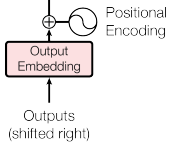

### Input Embeddings

In [13]:
# define input embedding table
input_embedding_table = nn.Embedding(num_embeddings=max_token_value+1, embedding_dim=d_model)

In [14]:
input_embedding_table.weight.shape, input_embedding_table.weight.data

(torch.Size([100070, 64]),
 tensor([[ 0.9451, -0.0579,  1.4938,  ..., -0.4981, -0.4865,  0.2160],
         [-0.0784, -0.1533, -0.2372,  ...,  0.9545,  0.2143,  0.3627],
         [ 0.3288,  0.8298, -0.0028,  ..., -0.7870,  0.7126,  0.9092],
         ...,
         [ 0.8765, -0.1583,  0.9267,  ...,  0.6848,  0.2111,  1.8861],
         [-1.2485,  0.2075,  0.5422,  ..., -0.3212,  0.0218,  0.2077],
         [-0.6370, -0.9095, -1.3544,  ..., -0.0763, -0.8278, -0.0036]]))

In [15]:
x_batch_embedding = input_embedding_table(x_batch)
y_batch_embedding = input_embedding_table(y_batch)

In [16]:
x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

### Positional Encoding

In [17]:
# get positional encoding
def get_positional_encoding(d_model, context_length):
    positional_encoding = torch.zeros(context_length, d_model)
    for pos in range(context_length):
        for i in range(0, d_model, 2):
            positional_encoding[pos, i] = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / d_model)), dtype=torch.float32))
            positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i + 1)) / d_model)), dtype=torch.float32))
    return positional_encoding

In [18]:
x = x_batch_embedding + get_positional_encoding(d_model, context_length)
y = y_batch_embedding + get_positional_encoding(d_model, context_length)

In [19]:
pd.DataFrame(x[0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,2.252992,0.309681,2.133701,1.572688,0.895407,-0.427821,0.636240,-1.386453,-1.459706,0.524490,...,-2.268501,1.756414,-0.346743,1.586184,-0.222022,1.789804,-2.792236,0.287873,-0.560198,1.964203
1,1.615070,0.345654,-1.441671,1.457273,-2.854946,2.289389,0.405712,0.383995,1.943039,2.397515,...,0.905491,0.377634,0.506436,1.987998,2.866583,0.236457,-1.597810,-1.235765,-0.990244,0.366136
2,1.041101,1.531074,2.520024,1.349214,0.499208,0.557660,0.338278,1.012000,0.703511,0.640154,...,0.359022,0.762636,-0.400371,0.400162,-0.984265,1.969636,0.196757,0.146885,-0.017410,0.999198
3,0.515453,0.386055,0.732608,0.906228,0.494356,0.498387,-0.265810,0.995604,0.248312,1.104181,...,-0.249080,-0.429154,1.150913,1.252732,1.875379,1.278463,-0.780358,1.186640,1.581816,0.243449
4,-0.089446,-1.128176,-0.420165,-0.098935,1.694657,-1.880533,3.066581,0.090638,-1.439317,0.454323,...,1.050803,1.254868,-1.999986,1.207444,1.259093,1.748834,0.054523,0.087158,-1.090712,2.506678
5,1.407161,0.241406,-0.292510,0.311948,2.387138,-0.248067,1.299814,0.393845,-0.355361,0.396159,...,2.045144,-0.606183,-0.480109,1.442186,-1.031045,1.937785,-0.135096,-0.005121,1.327308,0.036783
6,0.424573,0.302212,-1.968629,-2.060987,1.317914,0.849149,0.923104,1.730461,2.355163,1.621525,...,-0.414955,1.199086,1.118449,0.564718,0.245140,3.422513,0.447419,0.801700,-0.556977,2.818614
7,0.364137,-0.187870,-1.365726,1.494483,0.726436,2.250088,0.043569,0.692775,1.732200,2.879547,...,0.131501,1.663490,1.993612,1.737953,0.236716,1.351343,1.246648,-1.123797,0.808286,-0.106441
8,-0.546872,1.373091,-2.091110,-0.977734,-0.537833,-0.868755,2.294862,1.491671,-0.139492,-0.163441,...,0.327400,0.864241,0.796668,0.355066,0.332901,-0.059098,0.711485,-0.013592,0.988185,2.832846
9,1.247130,-0.144775,-1.128181,0.309411,-1.085660,-1.192899,2.227370,1.351346,0.511083,0.463743,...,-1.112166,2.285117,0.643133,2.141904,-0.152970,-0.086737,0.321460,-0.008139,0.459326,3.745661


## Transformer Block

### Maksed Multi-Head Attention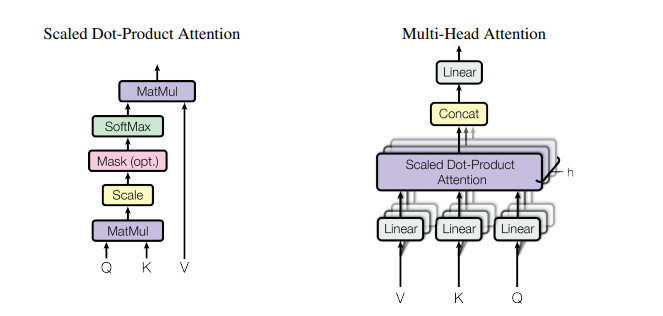


In [20]:
# get Q, K, V
Wq = nn.Linear(in_features=d_model, out_features=d_model)
Wk = nn.Linear(in_features=d_model, out_features=d_model)
Wv = nn.Linear(in_features=d_model, out_features=d_model)

Q = Wq(x)  # Wq*x
K = Wk(x)  # Wk*x
V = Wv(x)  # Wv*x

In [21]:
Q.shape, K.shape, V.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [22]:
# apply multi head
Q = Q.view(batch_size, context_length, num_heads, d_model // num_heads)
K = K.view(batch_size, context_length, num_heads, d_model // num_heads)
V = V.view(batch_size, context_length, num_heads, d_model // num_heads)

Q = Q.permute(0, 2, 1, 3)
K = K.permute(0, 2, 1, 3)
V = V.permute(0, 2, 1, 3)

In [23]:
Q.shape, K.shape, V.shape

(torch.Size([4, 4, 16, 16]),
 torch.Size([4, 4, 16, 16]),
 torch.Size([4, 4, 16, 16]))

In [24]:
# apply scaled dot-product
output = Q @ K.transpose(-2, -1) / math.sqrt(d_model // num_heads)

In [25]:
# apply mask
mask = torch.tril(torch.ones(context_length, context_length))
output = output.masked_fill(mask == 0, float('-inf'))

In [26]:
# apply softmax
attention_score = F.softmax(output, dim=-1)

In [27]:
# apply attention @ V
A = attention_score @ V

In [28]:
# apply concat
A = A.transpose(1, 2).contiguous().view(batch_size, context_length, d_model)
Wo = nn.Linear(in_features=d_model, out_features=d_model)
output = Wo(A)

In [29]:
output.shape

torch.Size([4, 16, 64])

### Add & Norm
add_norm.png



In [30]:
# apply residual connection
output = output + x

In [31]:
# apply layer normalization
layer_norm = nn.LayerNorm(d_model)
layer_norm_output = layer_norm(output)

### Feed Forward Network

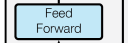

In [32]:
# apply feed forware network
output = nn.Linear(in_features=d_model, out_features=d_model * 4)(layer_norm_output)
output = nn.ReLU()(output)
output = nn.Linear(in_features=d_model * 4, out_features=d_model)(output)

In [33]:
# apply Add & Norm
output = output + layer_norm_output
output = layer_norm(output)
output.shape

torch.Size([4, 16, 64])

## Linear

In [34]:
# define final linear layer
output = nn.Linear(in_features=d_model, out_features=max_token_value+1)(output)

output.shape

torch.Size([4, 16, 100070])

## Softmax and Output Probabilities

In [35]:
# apply softmax to get output probabilities
logits = F.softmax(output, dim=-1)

In [36]:
# get the final output
predicted_indx = torch.argmax(logits[0, 0], dim=-1).item()

# decode
enc.decode([predicted_indx])

' SEAL'